This notebook checks our windows against those used in Freeman and Simoncelli, 2011, to make sure our implementation doesn't differ too much. In order to use this, first run the `freeman_check` rule in Snakemake (or, if you don't have matlab or don't wish to set it up, download the outputs from OSF using `download_freeman_check` Snakemake rule): `snakemake -prk freeman_check` or `snakemake -prk download_freeman_check` (after setting up and activating the `metamer` python environment as explained in this repo's README).

In [2]:
import pyrtools as pt
import plenoptic as po
import os.path as op
import numpy as np
import matplotlib.pyplot as plt
import h5py
import imageio

import sys
sys.path.append('..')
sys.path.append('../extra_packages/pooling-windows/')
import pooling
import foveated_metamers as fov

%matplotlib inline
%load_ext autoreload
%autoreload 2
#%load_ext line_profiler

import yaml

with open('../config.yml') as f:
    DATA_DIR = yaml.safe_load(f)['DATA_DIR']
# if DATA_DIR is a relative path, it assumes we're in the directory above, the root of this repo
if not DATA_DIR.startswith('/'):
    DATA_DIR = op.join('..', DATA_DIR)

# Check windows

Let's do some quick checks to make sure our windows are comparable to the original implementation.

## Scaling 0.5

In [2]:
with h5py.File(op.join(DATA_DIR, 'freeman_check/windows/scaling-0.5/plotwindows.mat'), 'r') as f:
    im = f['im'][:]
    
with h5py.File(op.join(DATA_DIR, 'freeman_check/windows/scaling-0.5/masks.mat'), 'r') as f:
    masks = f[f['scale'][1, 0]]['maskMat'][:]

Those windows were created with a scaling value of .5, on a 512x512 image, maximum eccentricity of 13 degrees, 4 scales. So we'll create our equivalent one:

In [3]:
pw = pooling.PoolingWindows(.5, (512, 512), max_eccentricity=13, num_scales=4)

../extra_packages/pooling-windows/pooling/pooling_windows.py:280: UserWarning: Creating windows for scale 2 with min_ecc 0.5, but calculated min_ecc is 0.648281205652328, so be aware some are smaller than a pixel!
  warnings.warn(f"Creating windows for scale {i} with min_ecc "
../extra_packages/pooling-windows/pooling/pooling_windows.py:280: UserWarning: Creating windows for scale 3 with min_ecc 0.5, but calculated min_ecc is 1.296562411304656, so be aware some are smaller than a pixel!
  warnings.warn(f"Creating windows for scale {i} with min_ecc "


On the left, this is the windows, as created by the `plotWindows` function in the [metamers](https://github.com/freeman-lab/metamers/) matlab code. I'm not entirely sure what the black and white correspond to, but it shows the approximate size. The right shows our windows, as created by [pooling-windows](https://github.com/LabForComputationalVision/pooling-windows) and used in our models. You can see they look approximately the same, but it's hard to directly compare.

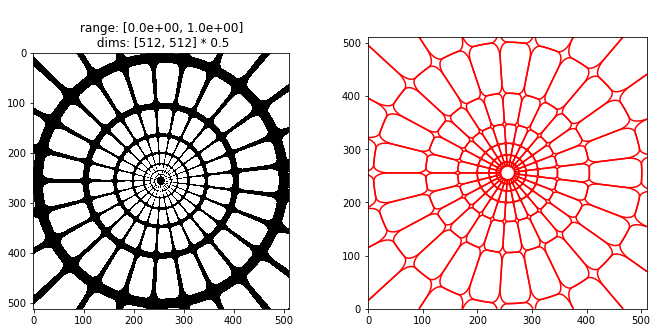

In [4]:
fig, axes = plt.subplots(1, 2, figsize=(11, 5))
pt.imshow([im[0]], ax=axes[0], zoom=.5);
pw.plot_windows(subset=False, ax=axes[1]);

Let's pick an arbitrary window from the matlab code and investigate it more closely:

In [5]:
mat_win = masks[..., -85]

Let's grab the window in approximately the same place from our windows. After a bit of trial and error, determined that the following is correct.

In [6]:
win = po.to_numpy(pw.ecc_windows[1][4])*po.to_numpy(pw.angle_windows[1][5])
# normalize so that max value is 1, to match matlab implementation
win /= win.max()

Now let's plot the two windows next to each other and then take their difference. We can see that they look the same, though, from their difference, it's clear that their exact angular position doesn't line up. Their length in the radial direction appears to be the same, as does their width in the angular direction

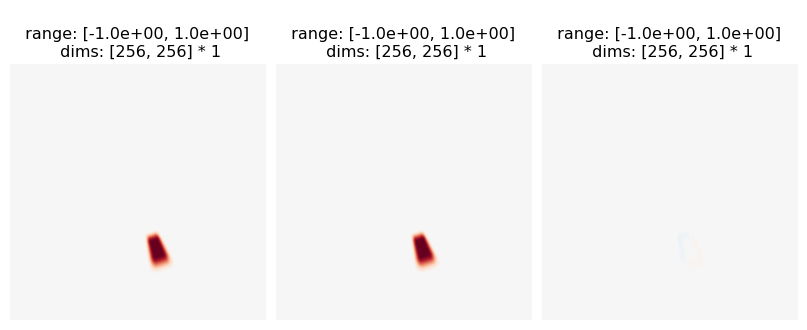

In [7]:
pt.imshow([mat_win, win, mat_win-win], vrange='auto0', );

We don't actually use these raised-cosine windows, though, so let's look at one of our Gaussian ones:

In [8]:
pw_gauss = pooling.PoolingWindows(.5, (512, 512), max_eccentricity=13, num_scales=5, 
                                  window_type='gaussian', std_dev=1)

../extra_packages/pooling-windows/pooling/pooling_windows.py:280: UserWarning: Creating windows for scale 4 with min_ecc 0.5, but calculated min_ecc is 2.593124822609312, so be aware some are smaller than a pixel!
  warnings.warn(f"Creating windows for scale {i} with min_ecc "


Again, pick the corresponding window. Note that indices are different here from above because there are far more Gaussian windows necessary to tile the image.

In [9]:
win_gauss = po.to_numpy(pw_gauss.ecc_windows[1][11])*po.to_numpy(pw_gauss.angle_windows[1][12])
# normalize so that max value is 1, to match matlab implementation
win_gauss /= win_gauss.max()

Do the same plot as above. Since the shape is different, it's a bit more difficult to decide whether we think they're the same size or not.

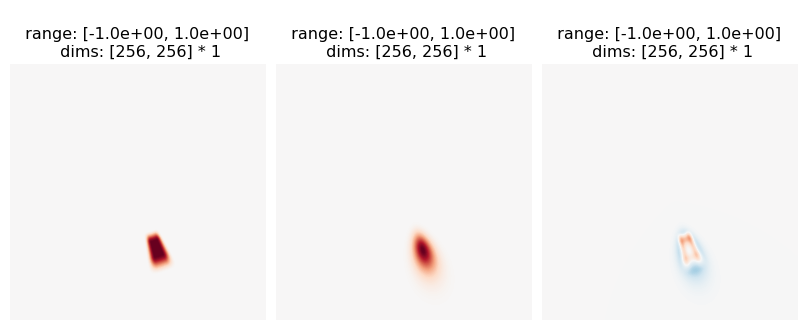

In [10]:
pt.imshow([mat_win, win_gauss, mat_win-win_gauss], vrange='auto0', );

Because of that, let's look at the sizes directly. Since we trust our raised-cosine windows are the same size as Jeremy's matlab implementation, let's compare our Gaussian windows directly to that, in both the radial and angular directions (in pixels). Note we're comparing the width at half-height, because that's how scaling is defined.

In [11]:
cos_r = pw.window_width_pixels[1]['radial_half'][4]
cos_a = pw.window_width_pixels[1]['angular_half'][4]
gauss_a = pw_gauss.window_width_pixels[1]['angular_half'][11]
gauss_r = pw_gauss.window_width_pixels[1]['radial_half'][11]
print(f"Raised-cosine window has widths:\n\tradial: {cos_r:.03f}\n\tangular: {cos_a:.03f}")
print(f"Gaussian window has widths:\n\tradial: {gauss_r:.03f}\n\tangular: {gauss_a:.03f}")

Raised-cosine window has widths:
	radial: 29.237
	angular: 14.619
Gaussian window has widths:
	radial: 30.659
	angular: 15.330


And they're pretty much the same (the small difference is due to the fact that their centers aren't in exactly the same location.

In [12]:
cos_ctr = pw.central_eccentricity_pixels[1][4]
gauss_ctr = pw_gauss.central_eccentricity_pixels[1][11]
print(f"Raised-cosine window has center at {cos_ctr:.03f} pixels")
print(f"Gaussian window has center at {gauss_ctr:.03f} pixels")

Raised-cosine window has center at 58.475 pixels
Gaussian window has center at 61.318 pixels


## Scaling 0.25

Now let's do that whole thing over again with scaling 0.25. Text is basically just duplicated from above.

In [13]:
with h5py.File(op.join(DATA_DIR, 'freeman_check/windows/scaling-0.25/plotwindows.mat'), 'r') as f:
    im = f['im'][:]
    
with h5py.File(op.join(DATA_DIR, 'freeman_check/windows/scaling-0.25/masks.mat'), 'r') as f:
    masks = f[f['scale'][1, 0]]['maskMat'][:]

In [14]:
pw = pooling.PoolingWindows(.25, (512, 512), max_eccentricity=13, num_scales=4)

../extra_packages/pooling-windows/pooling/pooling_windows.py:280: UserWarning: Creating windows for scale 1 with min_ecc 0.5, but calculated min_ecc is 0.648281205652328, so be aware some are smaller than a pixel!
  warnings.warn(f"Creating windows for scale {i} with min_ecc "
../extra_packages/pooling-windows/pooling/pooling_windows.py:280: UserWarning: Creating windows for scale 2 with min_ecc 0.5, but calculated min_ecc is 1.296562411304656, so be aware some are smaller than a pixel!
  warnings.warn(f"Creating windows for scale {i} with min_ecc "
../extra_packages/pooling-windows/pooling/pooling_windows.py:280: UserWarning: Creating windows for scale 3 with min_ecc 0.5, but calculated min_ecc is 2.593124822609312, so be aware some are smaller than a pixel!
  warnings.warn(f"Creating windows for scale {i} with min_ecc "


On the left, this is the windows, as created by the `plotWindows` function in the [metamers](https://github.com/freeman-lab/metamers/) matlab code. I'm not entirely sure what the black and white correspond to, but it shows the approximate size. The right shows our windows, as created by [pooling-windows](https://github.com/LabForComputationalVision/pooling-windows) and used in our models. You can see they look approximately the same, but it's hard to directly compare.

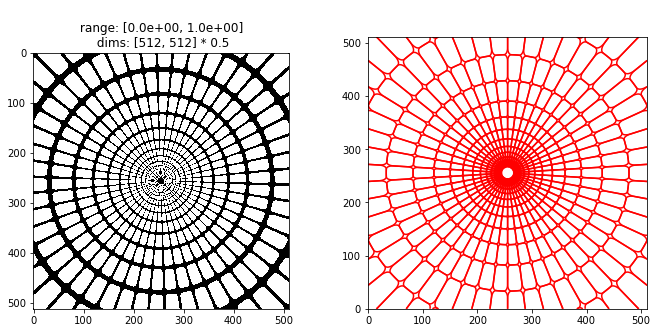

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(11, 5))
pt.imshow([im[0]], ax=axes[0], zoom=.5);
pw.plot_windows(subset=False, ax=axes[1]);

Let's pick an arbitrary window from the matlab code and investigate it more closely:

In [16]:
mat_win = masks[..., -355]

Let's grab the window in approximately the same place from our windows. After a bit of trial and error, determined that the following is correct.

In [17]:
win = po.to_numpy(pw.ecc_windows[1][10])*po.to_numpy(pw.angle_windows[1][11])
# normalize so that max value is 1, to match matlab implementation
win /= win.max()

Now let's plot the two windows next to each other and then take their difference. We can see that they look the same, though, from their difference, it's clear that their exact angular position doesn't line up. Their length in the radial direction appears to be the same, as does their width in the angular direction

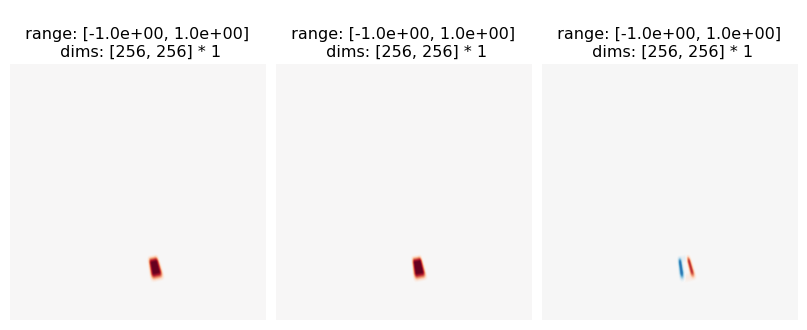

In [18]:
pt.imshow([mat_win, win, mat_win-win], vrange='auto0', );

We don't actually use these raised-cosine windows, though, so let's look at one of our Gaussian ones:

In [19]:
pw_gauss = pooling.PoolingWindows(.25, (512, 512), max_eccentricity=13, num_scales=5, 
                                  window_type='gaussian', std_dev=1)

../extra_packages/pooling-windows/pooling/pooling_windows.py:280: UserWarning: Creating windows for scale 4 with min_ecc 0.5, but calculated min_ecc is 5.186249645218624, so be aware some are smaller than a pixel!
  warnings.warn(f"Creating windows for scale {i} with min_ecc "


Again, pick the corresponding window. Note that indices are different here from above because there are far more Gaussian windows necessary to tile the image.

In [20]:
win_gauss = po.to_numpy(pw_gauss.ecc_windows[1][25])*po.to_numpy(pw_gauss.angle_windows[1][25])
# normalize so that max value is 1, to match matlab implementation
win_gauss /= win_gauss.max()

Do the same plot as above. Since the shape is different, it's a bit more difficult to decide whether we think they're the same size or not.

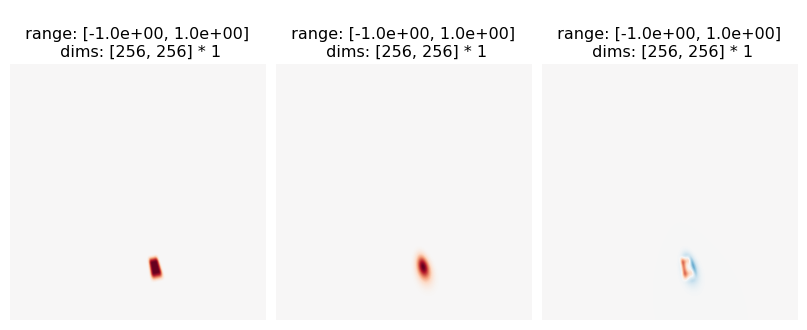

In [21]:
pt.imshow([mat_win, win_gauss, mat_win-win_gauss], vrange='auto0', );

Because of that, let's look at the sizes directly. Since we trust our raised-cosine windows are the same size as Jeremy's matlab implementation, let's compare our Gaussian windows directly to that, in both the radial and angular directions (in pixels). Note we're comparing the width at half-height, because that's how scaling is defined.

In [22]:
cos_r = pw.window_width_pixels[1]['radial_half'][10]
cos_a = pw.window_width_pixels[1]['angular_half'][10]
gauss_a = pw_gauss.window_width_pixels[1]['angular_half'][25]
gauss_r = pw_gauss.window_width_pixels[1]['radial_half'][25]
print(f"Raised-cosine window has widths:\n\tradial: {cos_r:.03f}\n\tangular: {cos_a:.03f}")
print(f"Gaussian window has widths:\n\tradial: {gauss_r:.03f}\n\tangular: {gauss_a:.03f}")

Raised-cosine window has widths:
	radial: 19.116
	angular: 9.558
Gaussian window has widths:
	radial: 19.313
	angular: 9.657


And they're pretty much the same (the small difference is due to the fact that their centers aren't in exactly the same location.

In [23]:
cos_ctr = pw.central_eccentricity_pixels[1][10]
gauss_ctr = pw_gauss.central_eccentricity_pixels[1][25]
print(f"Raised-cosine window has center at {cos_ctr:.03f} pixels")
print(f"Gaussian window has center at {gauss_ctr:.03f} pixels")

Raised-cosine window has center at 76.464 pixels
Gaussian window has center at 77.253 pixels


# Compare metamers

While the [posted code](https://github.com/freeman-lab/metamers/) does not include the V1 model (only the mid-ventral / texture model), supplementary figure 2 of the paper contains two example metamers, with the "scaling parameter ... selected to yield 75% correct performance".  From looking at figure 4, this appears to vary from about .3 to .6, depending on the participant.

First, lets load in those images, as extracted from the pdf (run Snakefile rule `download_freeman_check_input` to download this from the [project's OSF](https://osf.io/67tbe/)).

In [24]:
freeman_mets = [imageio.imread(op.join(DATA_DIR, 'ref_images', 'fountain_size-512,512.png'))] 
freeman_mets += [imageio.imread(op.join(DATA_DIR, 'freeman_check', 'Freeman2011_metamers', f'metamer{i+1}.png')) 
                for i in range(2)] 
freeman_mets = np.array(freeman_mets)
# when loaded, each image is 3d (separate channels for each of RGBA), 
# but these are grayscale images, so we convert it to 2d
# alpha channel is constant 255, so we drop it
assert (freeman_mets[..., -1] == 255).all(), "Alpha channel should have all 255 values!"
freeman_mets = freeman_mets[..., :3]
# RGB channels are all equal
assert (freeman_mets.var(-1) == 0).all(), "RGB channels should all be identical!"
freeman_mets = freeman_mets.mean(-1)

Then let's load in the metamers created by our model (run the `freeman_check` or `download_freeman_check` rules to create / download these; creating them will require a GPU).

In [25]:
scaling = [.3, .4, .5]
fov_mets = fov.utils.generate_metamer_paths(model_name='V1_norm_s4_gaussian', image_name='fountain_size-512,512',
                                            scaling=scaling, max_ecc=13, gpu=1, seed=0)
fov_mets = np.array([imageio.imread(m) for m in fov_mets])

The following figure allows us to compare these metamers: the first row shows the natural image the metamers are based on, the second shows the two example metamers from Freeman and Simoncelli, 2011, and the final one shows the metamers we synthesized with comparable scaling values.

Freeman and Simoncelli's metamers look comparable to ours with scaling 0.3 or 0.4 and, while not identical, the distortions are similar and are approximately the same scale. Note that this is true even though our metamers were generated using the Gaussian windows instead of the raised-cosine ones used in Freeman and Simoncelli. (Note that these images should be viewed at full resolution; the noise present in the images can get slightly weird when they're shrunk to fewer pixels. If your notebook isn't big enough for this, uncomment the last line in the block below to save the figure and open it externally, so you can zoom to 100% and pan around.)

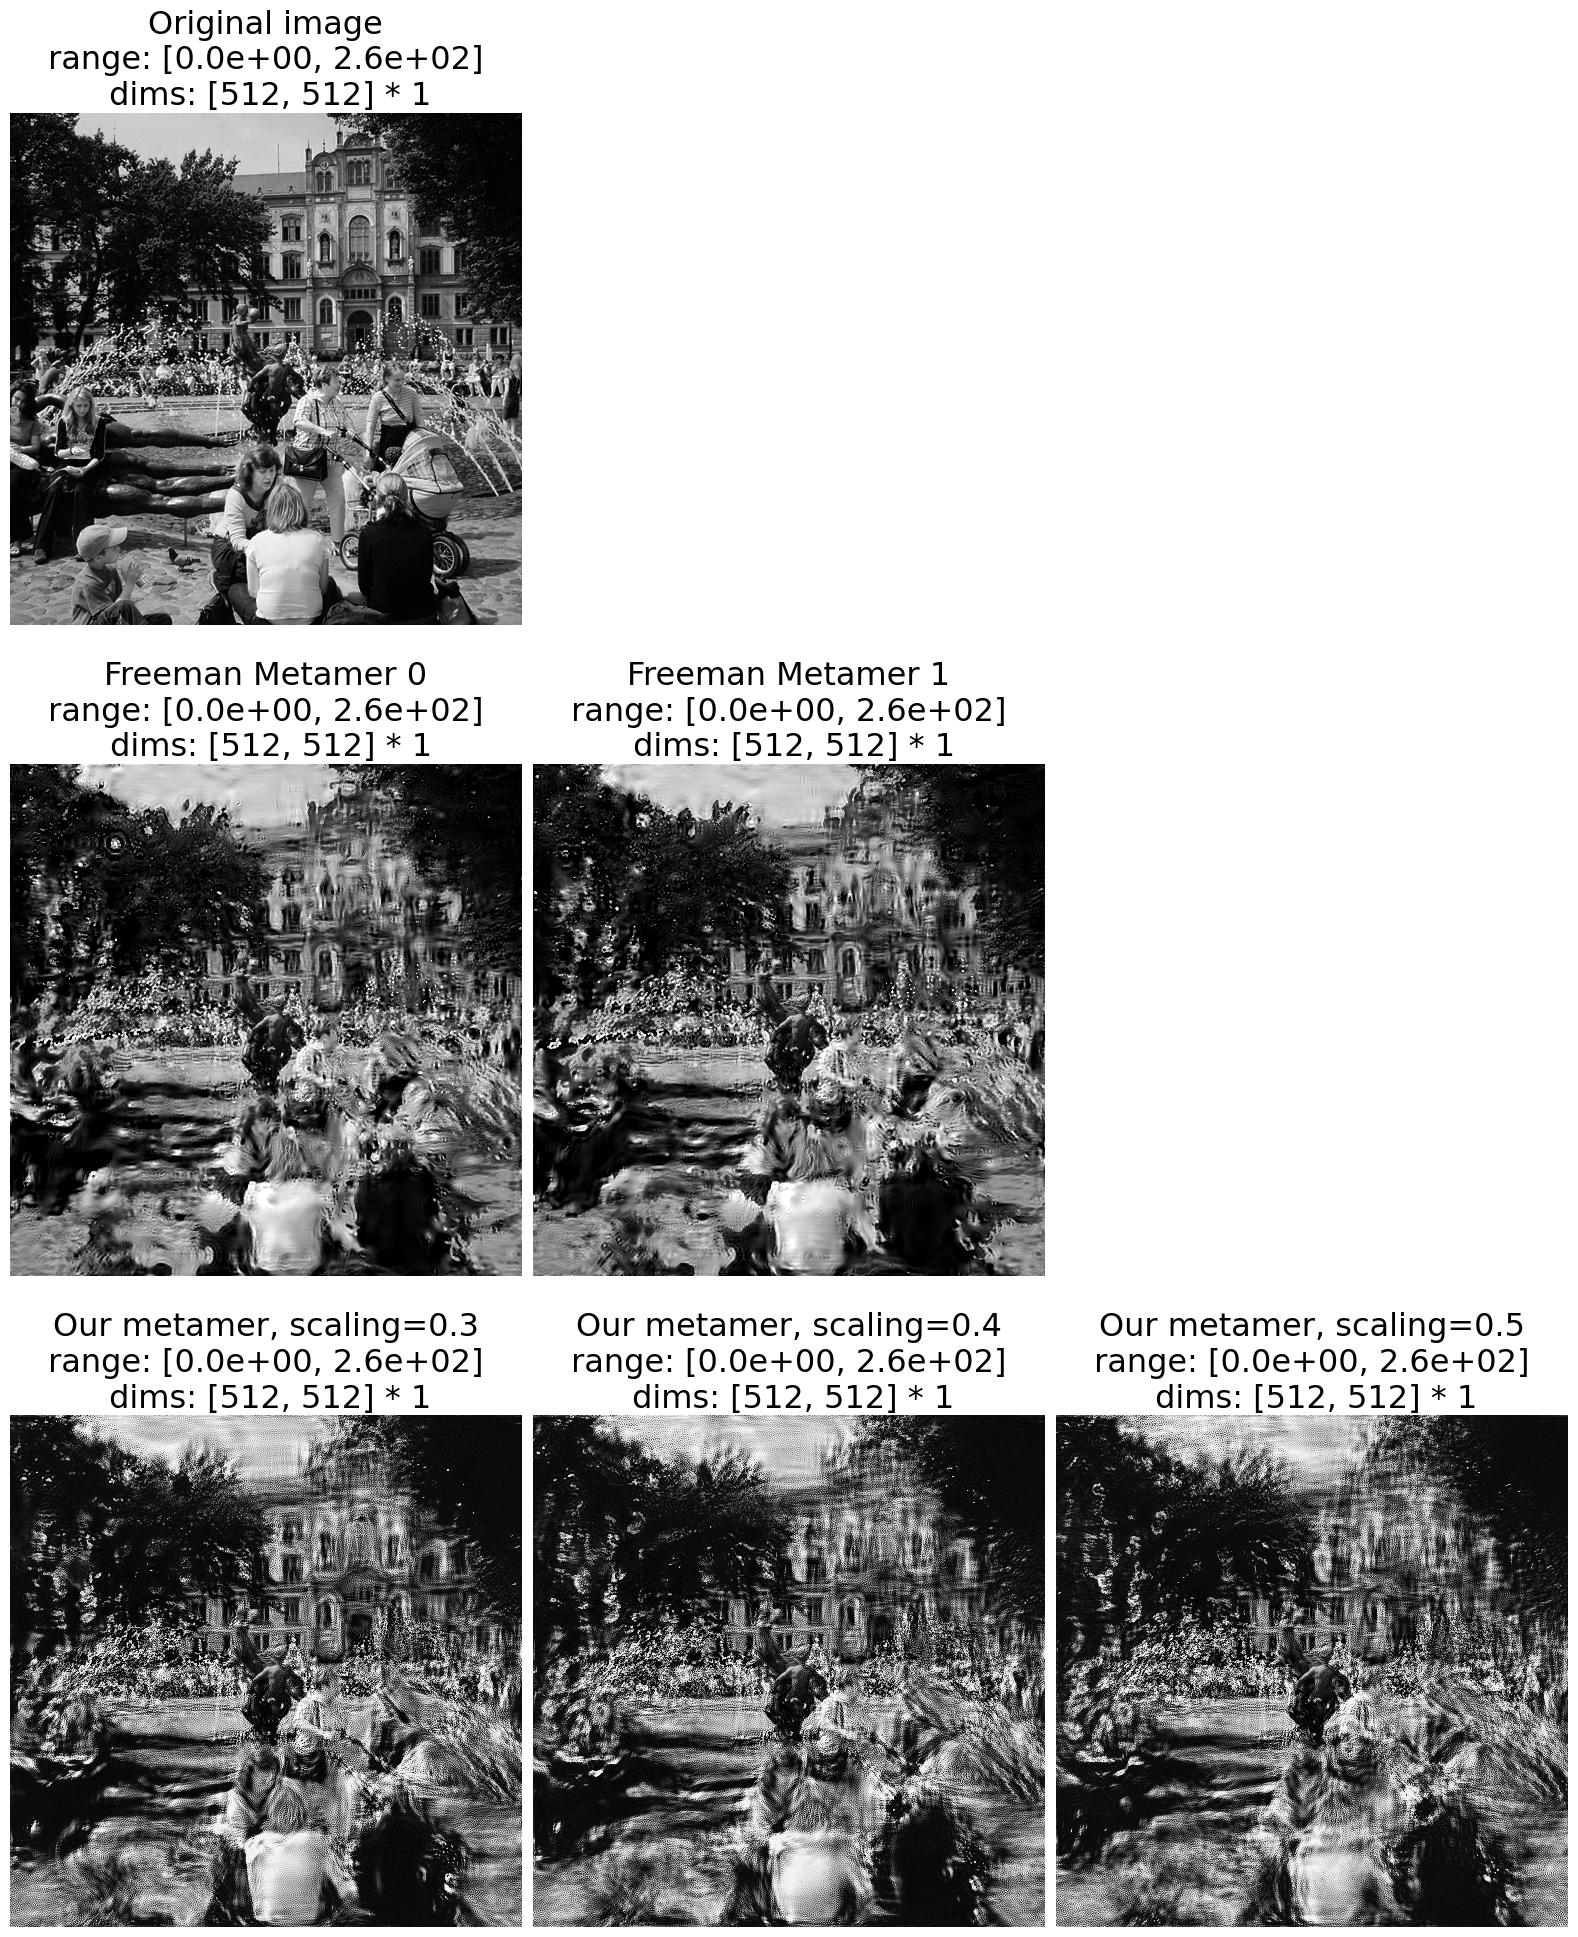

In [26]:
zoom = 1
fig = pt.tools.display.make_figure(3, len(scaling), [zoom*i+1 for i in freeman_mets.shape[-2:]], vert_pct=.8)
pt.imshow(freeman_mets[0], ax=fig.axes[0], title="Original image", zoom=zoom, vrange=(0, 255))
for i, (m, ax) in enumerate(zip(freeman_mets[1:], fig.axes[len(scaling):len(scaling)+2])):
    pt.imshow(m, ax=ax, title=f"Freeman Metamer {i}", zoom=zoom, vrange=(0, 255))
for i, (m, ax) in enumerate(zip(fov_mets, fig.axes[2*len(scaling):])):
    pt.imshow(m, ax=ax, title=f"Our metamer, scaling={scaling[i]}", zoom=zoom, vrange=(0, 255))
# uncomment the following line to save the figure
# fig.savefig('metamer_comparison.png')